In [3]:

# 필요 패키지 import
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [5]:
# 1. DATA LOAD
# Kaggle에서 제공하는 [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data)데이터를 활용
# BNP Paribas Cardif 청구관리 데이터 셋으로 고객의 클레임 여부를 판단하는 데이터셋의 Subset
DATA_PATH = "c:\\Users\\WAI\\OneDrive\\03.WORKSPACE\\00.DATA\\"
df = pandas.read_csv(DATA_PATH + "BookExample.csv")
print(df.shape) # (20000, 33)

# 연속형 변수만 추출
n_obj_cols = []
for col, type in zip(df.dtypes.index, df.dtypes.values):
    if type != ("object"):
        n_obj_cols.append(col)

n_obj_df = df[n_obj_cols]
print(n_obj_df.shape)


# 학습, 검증 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(n_obj_df.drop(labels=["ID","target"], axis=1),
                                                    n_obj_df["target"],
                                                    test_size=0.2,
                                                    random_state=42)

print("Train Shape : {0}, Test Shape : {1}".format(train_x.shape, test_x.shape))

(20000, 33)
(20000, 28)
Train Shape : (16000, 26), Test Shape : (4000, 26)


In [10]:
# Forward Sequential Feature Selection
# 전진적 순차 변수 선택법
# mlxtent 모듈에서 제공하는 SequentialFeatureSelector API를 사용한 Feature Selection을 
# 수행해보겠습니다.

#1. Step Forward Feature Selection(SFS)
# SequentialFeatureSelector를 사용한 Feature Selection
# 적합시킬 모델은 RandomForest Classifier에
# k_feature : 선택할 변수의 갯수(int)
# forward : step forward selection(True/false)
# verbose : logging level parameter(int)
# scoring : performance evaluation criteria and finally(string)
# cv : cross validation folds(int)

# Selector 객체 선언
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10, n_jobs=-1),
                                            k_features=5,
                                            forward=True,
                                            verbose=2,
                                            scoring='roc_auc',
                                            cv=4)

# 변수 선택 수행
features = feature_selector.fit(numpy.array(train_x.fillna(0)), train_y,
                                custom_feature_names=)  

# 결과 출력
filtered_features = train_x.columns[list(features.k_feature_idx_)]
print(filtered_features)                             



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   22.1s finished

[2021-07-13 15:54:16] Features: 1/5 -- score: 0.6123790705613947[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   19.4s finished

[2021-07-13 15:54:35] Features: 2/5 -- score: 0.6386292426241305[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   19.4s finished

[2021-07-13 15:54:55] Features: 3/5 -- score: 0.6576746709342768[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

Index(['v8', 'v10', 'v12', 'v18', 'v23'], dtype='object')


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   19.0s finished

[2021-07-13 15:55:34] Features: 5/5 -- score: 0.6329004904980484

In [8]:
# 선택된 변수로 radomforest 모델링 수행

clf = RandomForestClassifier(n_estimators=100, random_state=41, max_depth=3)
clf.fit(train_x[filtered_features].fillna(0), train_y)
train_pred = clf.predict_proba(train_x[filtered_features].fillna(0))
print('Accuracy Train Set : {}'.format(roc_auc_score(train_y, train_pred[:,1])))

test_pred = clf.predict_proba(test_x[filtered_features].fillna(0))
print('Accuracy Test Set : {}'.format(roc_auc_score(test_y, test_pred[:,1])))

Accuracy Train Set : 0.6746491815435629
Accuracy Test Set : 0.6583889208301897


          feature_idx                                          cv_scores  \
1                (8,)  [0.6085661347827036, 0.625757587114852, 0.6044...   
2             (8, 10)  [0.6315368507272291, 0.642126375139013, 0.6352...   
3         (8, 10, 20)  [0.6452550208247018, 0.6654427497873918, 0.655...   
4      (6, 8, 10, 20)  [0.6198490209119257, 0.6457327078654136, 0.617...   
5  (6, 8, 10, 16, 20)  [0.6178430419873961, 0.6435452964521686, 0.632...   

  avg_score             feature_names  ci_bound   std_dev   std_err  
1  0.612379                    (v10,)  0.012894  0.008044  0.004644  
2  0.638629                (v10, v12)  0.008861  0.005528  0.003191  
3  0.657675           (v10, v12, v23)  0.013204  0.008237  0.004756  
4  0.632301       (v8, v10, v12, v23)  0.021657  0.013511    0.0078  
5    0.6329  (v8, v10, v12, v18, v23)  0.015346  0.009573  0.005527  


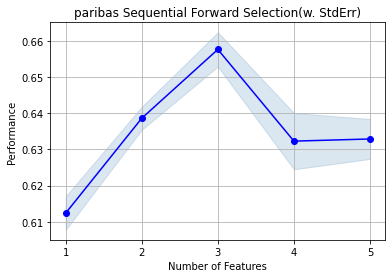

In [12]:
# 전진적 변수 선택에서 각 변수 선택별 결과 확인
# 
result = pandas.DataFrame.from_dict(features.get_metric_dict()).T
print(result.head())
#result.to_csv("SFS_result.csv",index=False)
fig = plot_sfs(features.get_metric_dict(), kind = 'std_err')
plt.title("paribas Sequential Forward Selection(w. StdErr)")
plt.grid()
plt.show()

# 결과에는 

In [15]:
# 2. Step BackWard Sequential Feature selection
# 후진적 변수선택법은 전진적 변수선택법의 파라미터중 forward 파라미터의 값을 False로 수정하면
# 사용할 수 있습니다.

# Selector 객체 선언
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10, n_jobs=-1),
                                            k_features=15,
                                            forward=False,
                                            verbose=2,
                                            scoring='roc_auc',
                                            cv=4)

# 변수 선택 수행
features = feature_selector.fit(numpy.array(train_x.fillna(0)), train_y,
                                custom_feature_names=train_x.columns)  

# 결과 출력
filtered_features = train_x.columns[list(features.k_feature_idx_)]
print(filtered_features)                             



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   47.0s finished

[2021-07-13 16:02:13] Features: 25/15 -- score: 0.6192374741735537[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   44.2s finished

[2021-07-13 16:02:57] Features: 24/15 -- score: 0.6200440821321878[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   42.1s finished

[2021-07-13 16:03:39] Features: 23/15 -- score: 0.618418770715672[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

Index(['v1', 'v5', 'v8', 'v9', 'v10', 'v12', 'v14', 'v16', 'v17', 'v18', 'v19',
       'v21', 'v26', 'v27', 'v28'],
      dtype='object')


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   15.3s finished

[2021-07-13 16:06:39] Features: 15/15 -- score: 0.6233069708236114

In [16]:
# 선택된 변수로 radomforest 모델링 수행

clf = RandomForestClassifier(n_estimators=100, random_state=41, max_depth=3)
clf.fit(train_x[filtered_features].fillna(0), train_y)
train_pred = clf.predict_proba(train_x[filtered_features].fillna(0))
print('Accuracy Train Set : {}'.format(roc_auc_score(train_y, train_pred[:,1])))

test_pred = clf.predict_proba(test_x[filtered_features].fillna(0))
print('Accuracy Test Set : {}'.format(roc_auc_score(test_y, test_pred[:,1])))

Accuracy Train Set : 0.665933671604129
Accuracy Test Set : 0.6497669796158589


                                          feature_idx  \
26  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
25  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
24  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
23  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  (0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...   

                                            cv_scores avg_score  \
26  [0.6162612573322576, 0.6081013950369611, 0.612...  0.609908   
25  [0.6169052148978389, 0.6271676497525023, 0.620...  0.619237   
24  [0.6137866204016659, 0.6324041491310319, 0.625...  0.620044   
23  [0.6014393303386467, 0.644494026526963, 0.6153...  0.618419   
22  [0.6018791976493163, 0.6406146080921957, 0.619...    0.6226   

                                        feature_names  ci_bound   std_dev  \
26  (v1, v2, v4, v5, v6, v7, v8, v9, v10, v11, v12...    0.0081  0.005053   
25  (v1, v4, v5, v6, v7, v8, v9, v10, v11, v12, v1...   0.00861  0.005371   
24  (v1, v4, v5, v6, v7

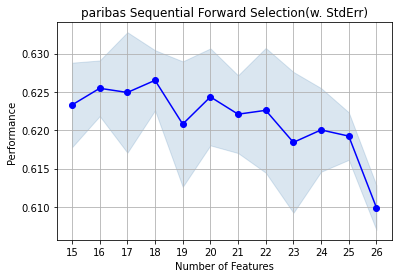

In [17]:
# 전진적 변수 선택에서 각 변수 선택별 결과 확인
# 
result = pandas.DataFrame.from_dict(features.get_metric_dict()).T
print(result.head())
#result.to_csv("SBS_result.csv",index=False)
fig = plot_sfs(features.get_metric_dict(), kind = 'std_err')
plt.title("paribas Sequential Forward Selection(w. StdErr)")
plt.grid()
plt.show()